# 0 准备数据

In [49]:
# 导入相关包
import numpy as np
import pandas as pd
from pandas import plotting

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn as sns
sns.set_style("whitegrid")

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier

In [50]:
# 导入数据集
iris = pd.read_csv('iris.csv', usecols=[0, 1, 2, 3, 4])

In [51]:
# 查看数据集信息
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [52]:
# 查看数据集的前5条记录
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# 1 探索性分析

In [53]:
# 先查看数据集各特征列的摘要统计信息
iris.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


通过`Violinplot`和`Pointplot`，分别从数据分布和斜率，观察各特征与品种之间的关系：

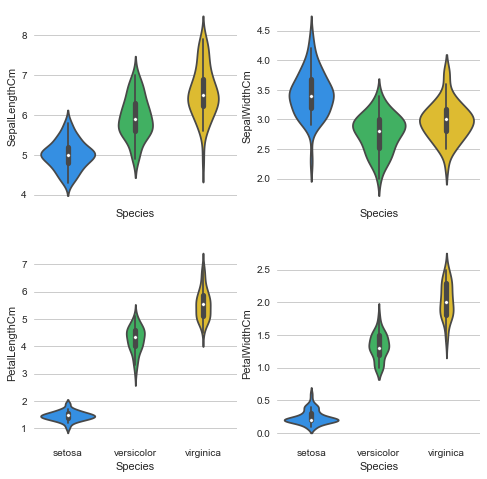

In [54]:
# 设置颜色主题
antV = ['#1890FF', '#2FC25B', '#FACC14', '#223273', '#8543E0', '#13C2C2', '#3436c7', '#F04864'] 

# 绘制Violinplot
f, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
sns.despine(left=True)
sns.violinplot(x='Species', y='SepalLengthCm', data=iris, palette=antV, ax=axes[0, 0])
sns.violinplot(x='Species', y='SepalWidthCm', data=iris, palette=antV, ax=axes[0, 1])
sns.violinplot(x='Species', y='PetalLengthCm', data=iris, palette=antV, ax=axes[1, 0])
sns.violinplot(x='Species', y='PetalWidthCm', data=iris, palette=antV, ax=axes[1, 1])

plt.show()

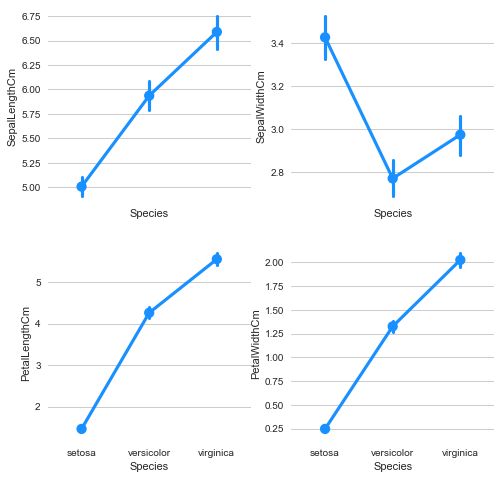

In [55]:
# 绘制pointplot
f, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
sns.despine(left=True)

sns.pointplot(x='Species', y='SepalLengthCm', data=iris, color=antV[0], ax=axes[0, 0])
sns.pointplot(x='Species', y='SepalWidthCm', data=iris, color=antV[0], ax=axes[0, 1])
sns.pointplot(x='Species', y='PetalLengthCm', data=iris, color=antV[0], ax=axes[1, 0])
sns.pointplot(x='Species', y='PetalWidthCm', data=iris, color=antV[0], ax=axes[1, 1])

plt.show()

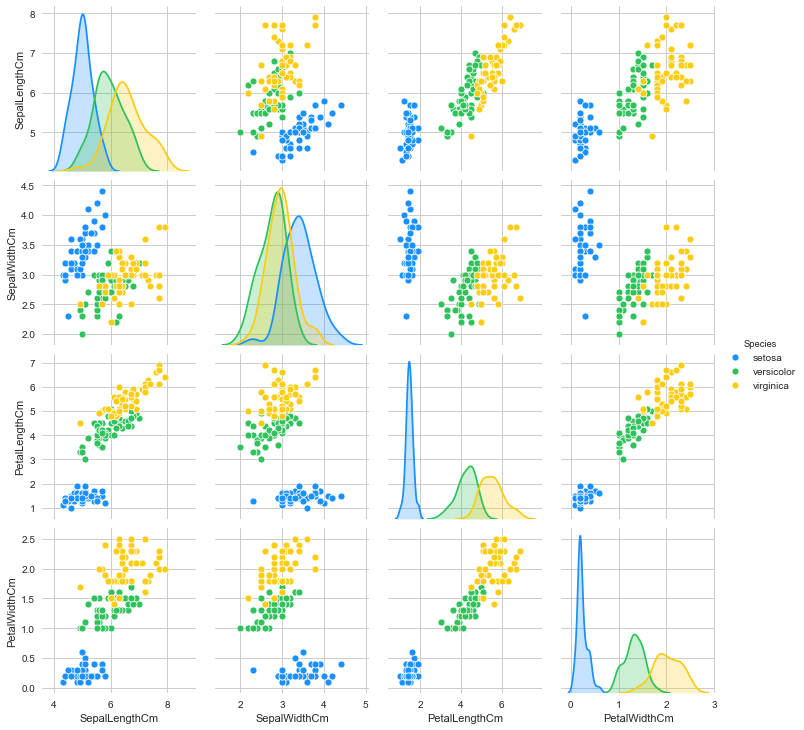

In [56]:
# 生成各特征之间关系的矩阵图：
g = sns.pairplot(data=iris, palette=antV, hue= 'Species')

使用 Andrews Curves 将每个多变量观测值转换为曲线并表示傅立叶级数的系数，这对于检测时间序列数据中的异常值很有用。
> Andrews Curves 是一种通过将每个观察映射到函数来可视化多维数据的方法。

/Users/liuning11/.conda/envs/myfaiss/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:241: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(-np.pi, np.pi))


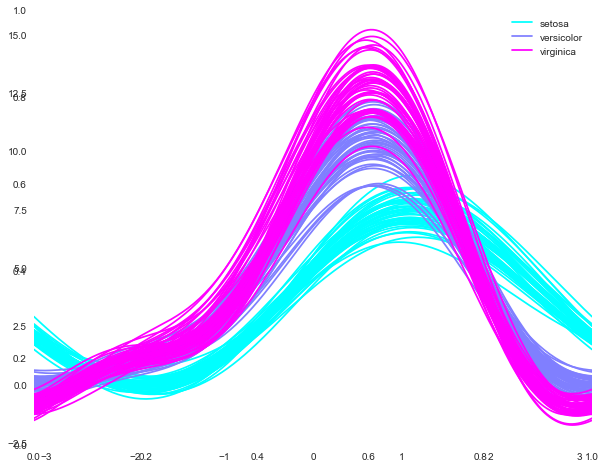

In [57]:
plt.subplots(figsize = (10,8))
plotting.andrews_curves(iris, 'Species', colormap='cool')

plt.show()

下面分别基于花萼和花瓣做线性回归的可视化：

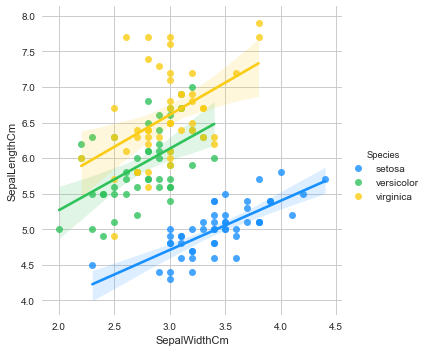

In [58]:
g = sns.lmplot(data=iris, x='SepalWidthCm', y='SepalLengthCm', palette=antV, hue='Species')

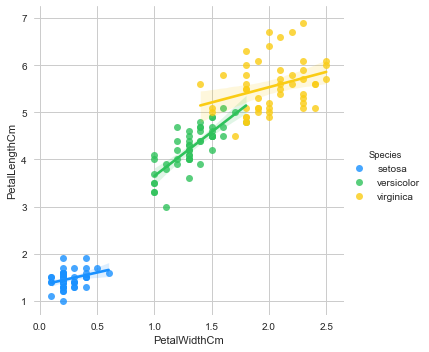

In [59]:
g = sns.lmplot(data=iris, x='PetalWidthCm', y='PetalLengthCm', palette=antV, hue='Species')

最后，通过热图找出数据集中不同特征之间的相关性，高正值或负值表明特征具有高度相关性：

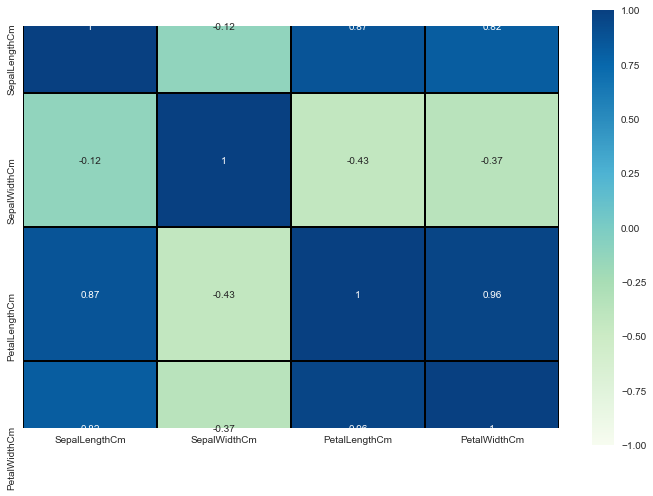

In [60]:
fig=plt.gcf()
fig.set_size_inches(12, 8)
fig=sns.heatmap(iris.corr(), annot=True, cmap='GnBu', linewidths=1, linecolor='k', square=True, mask=False, vmin=-1, vmax=1, cbar_kws={"orientation": "vertical"}, cbar=True)

从热图可看出，花萼的宽度和长度不相关，而花瓣的宽度和长度则高度相关。

# 2 机器学习
接下来，通过机器学习，以花萼和花瓣的尺寸为根据，预测其品种。

在进行机器学习之前，将数据集拆分为训练和测试数据集。首先，使用标签编码将 3 种鸢尾花的品种名称转换为分类值（0, 1, 2）。

In [61]:
# 载入特征和标签集
X = iris[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
y = iris['Species']

In [62]:
# 对标签集进行编码
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


接着，将数据集以 7: 3 的比例，拆分为训练数据和测试数据：

In [63]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 101)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(105, 4) (105,) (45, 4) (45,)


## 检查不同模型的准确性

### svm

In [64]:
# Support Vector Machine
model = svm.SVC()
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of the SVM is: {0}'.format(metrics.accuracy_score(prediction,test_y)))

The accuracy of the SVM is: 0.9777777777777777


### LogisticRegression

In [65]:
# Logistic Regression
model = LogisticRegression()
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of the Logistic Regression is: {0}'.format(metrics.accuracy_score(prediction,test_y)))

The accuracy of the Logistic Regression is: 0.9777777777777777


/Users/liuning11/.conda/envs/myfaiss/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Decision Tree

In [66]:
model=DecisionTreeClassifier()
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of the Decision Tree is: {0}'.format(metrics.accuracy_score(prediction,test_y)))

The accuracy of the Decision Tree is: 0.9555555555555556


### K-Nearest Neighbours

In [67]:
model=KNeighborsClassifier(n_neighbors=3)
model.fit(train_X, train_y)
prediction = model.predict(test_X)
print('The accuracy of the KNN is: {0}'.format(metrics.accuracy_score(prediction,test_y)))

The accuracy of the KNN is: 1.0


上面使用了数据集的所有特征，下面将分别使用花瓣和花萼的尺寸：

In [68]:
petal = iris[['PetalLengthCm', 'PetalWidthCm', 'Species']]
train_p,test_p=train_test_split(petal,test_size=0.3,random_state=0) 
train_x_p=train_p[['PetalWidthCm','PetalLengthCm']]
train_y_p=train_p.Species
test_x_p=test_p[['PetalWidthCm','PetalLengthCm']]
test_y_p=test_p.Species

sepal = iris[['SepalLengthCm', 'SepalWidthCm', 'Species']]
train_s,test_s=train_test_split(sepal,test_size=0.3,random_state=0)
train_x_s=train_s[['SepalWidthCm','SepalLengthCm']]
train_y_s=train_s.Species
test_x_s=test_s[['SepalWidthCm','SepalLengthCm']]
test_y_s=test_s.Species

In [69]:
model=svm.SVC()
model.fit(train_x_p,train_y_p) 
prediction=model.predict(test_x_p) 
print('The accuracy of the SVM using Petals is: {0}'.format(metrics.accuracy_score(prediction,test_y_p)))

model = LogisticRegression()
model.fit(train_x_p, train_y_p) 
prediction = model.predict(test_x_p) 
print('The accuracy of the Logistic Regression using Petals is: {0}'.format(metrics.accuracy_score(prediction,test_y_p)))

model.fit(train_x_s, train_y_s) 
prediction = model.predict(test_x_s) 
print('The accuracy of the Logistic Regression using Sepals is: {0}'.format(metrics.accuracy_score(prediction,test_y_s)))

model=DecisionTreeClassifier()
model.fit(train_x_p, train_y_p) 
prediction = model.predict(test_x_p) 
print('The accuracy of the Decision Tree using Petals is: {0}'.format(metrics.accuracy_score(prediction,test_y_p)))

model.fit(train_x_s, train_y_s) 
prediction = model.predict(test_x_s) 
print('The accuracy of the Decision Tree using Sepals is: {0}'.format(metrics.accuracy_score(prediction,test_y_s)))

model=KNeighborsClassifier(n_neighbors=3) 
model.fit(train_x_p, train_y_p) 
prediction = model.predict(test_x_p) 
print('The accuracy of the KNN using Petals is: {0}'.format(metrics.accuracy_score(prediction,test_y_p)))

The accuracy of the SVM using Petals is: 0.9777777777777777
The accuracy of the Logistic Regression using Petals is: 0.9777777777777777
The accuracy of the Logistic Regression using Sepals is: 0.8222222222222222
The accuracy of the Decision Tree using Petals is: 0.9555555555555556
The accuracy of the Decision Tree using Sepals is: 0.6666666666666666
The accuracy of the KNN using Petals is: 0.9777777777777777


从中不难看出，使用花瓣的尺寸来训练数据较花萼更准确。正如在探索性分析的热图中所看到的那样，花萼的宽度和长度之间的相关性非常低，而花瓣的宽度和长度之间的相关性非常高。